# Figure 1: linear stability

In [1]:
import sys
from math import cos, exp, pi, sin
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from numba import jit

sys.path.append("../code/")

import xgi
from hypersync_draw import *
from hypersync_generate import *
from hypersync_identify import *
from hypersync_integrate import *

sb.set_theme(style="ticks", context="paper")

results_dir = "../results/"
data_dir = "../data/"

Path(results_dir).mkdir(parents=True, exist_ok=True)
Path(data_dir).mkdir(parents=True, exist_ok=True)

## Spectrum

In [2]:
@jit
def lambda2(N, K1, K2, q, r):
    """
    Computes the lambda_max from Eq 5

    Parameters
    ----------
    N : int
        Number of nodes
    K1 : float
        Pairwise coupling strength
    K2 : float
        Triadic coupling strength
    q : int
        Winding number (number of twists of twisted state)
    r : int
        Coupling range (for ring structure)

    Returns
    -------
    lambda_2 : float
        Maximum non-zeros Lyapunov exponent
    """
    a2 = K1 * cos(2 * np.pi * q / N) / (2 * r)
    a3 = K1 * cos(4 * np.pi * q / N) / (2 * r)
    a1 = -2 * (a2 + a3)

    b2 = K2 * (1 + cos(2 * np.pi * q / N) + cos(6 * np.pi * q / N)) / (r * (2 * r - 1))
    b3 = K2 * (1 + cos(2 * np.pi * q / N) + cos(6 * np.pi * q / N)) / (r * (2 * r - 1))
    b1 = -2 * (b2 + b3)

    A1 = a1 + b1
    A2 = a2 + b2
    A3 = a3 + b3

    Lambda = np.zeros(N, dtype=np.complex_)
    for i in range(N):
        Lambda[i] = (
            A1
            + A2 * np.exp(2j * np.pi * i / N)
            + A3 * np.exp(2j * np.pi * i * 2 / N)
            + A2 * np.exp(2j * np.pi * i * (N - 1) / N)
            + A3 * np.exp(2j * np.pi * i * (N - 2) / N)
        )

    Lambda = np.real(Lambda)
    lambda_2 = np.sort(Lambda[1:])[-1]

    return lambda_2

/Users/maxime/.pyenv/versions/venv_xgi/lib/python3.9/site-packages/labellines/core.py:148: UserWarning: Tried to label line Line2D(_child5), but could not find a label for it.
  warnings.warn(


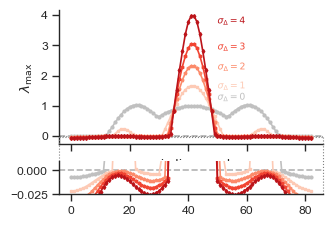

In [3]:
m = 5
N = 83
r = 2
r1 = 1
r2 = range(m)
Lambda_2 = np.zeros((N, m), dtype=np.complex_)

for q in range(N):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N, r1, r2[j], q, r)

fig, (ax, axins1) = plt.subplots(
    2, 1, figsize=(3.4, 2.4), height_ratios=[4, 1], sharex=True
)

ax.set_xlabel(r"$q$, winding number")
ax.set_ylabel(r"$\lambda_\mathrm{max}$")

markers = ["o", "s", "p", "h", "d"]
labels = [rf"$\sigma_\Delta={i}$" for i in range(5)]
colors = ["silver"] + sb.color_palette("Reds", n_colors=len(labels) - 1)

for i in range(m):
    ax.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker=markers[i],
        ms=2,
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )

ax.axhline(0, linestyle="--", alpha=0.6, c="grey", zorder=-2)


from labellines import labelLine, labelLines

legs = labelLines(
    ax.get_lines(),
    zorder=2.5,
    xvals=[40] * 5,
    yoffsets=[0.3] + [0.05] * 5,
    fontsize="x-small",
    align=False,
)
x_offset = 15
for leg in legs:
    x, y = leg.get_position()
    leg.set_position((x + x_offset, y))


for i in range(m):
    axins1.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker=markers[i],
        ms=2,
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )

axins1.set_ylim(ymax=0.01, ymin=-0.025)
axins1.axhline(0, linestyle="--", alpha=0.6, c="grey", zorder=-2)
axins1.set_ylabel("")

mark_inset(ax, axins1, loc1=2, loc2=4, ec="0.5", ls=":")

sb.despine()

#plt.savefig("lambda2.pdf")

In [4]:
np.where(Lambda_2.real[:, 4] < 0 )

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]),)

In [5]:
np.where(Lambda_2.real[:, 0] < 0 )

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 72, 73, 74, 75, 76,
        77, 78, 79, 80, 81, 82]),)

## Fraction of stable states

In [6]:
m = 50
N1 = 83
N2 = 830
r = 2
k1 = 1
k2 = np.linspace(0, 4, num=m)

Lambda_2 = np.zeros((N1, m), dtype=np.complex_)
for q in range(N1):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N1, k1, k2[j], q, r)
stable_fraction1 = np.mean(Lambda_2 < 0, axis=0)

Lambda_2 = np.zeros((N2, m), dtype=np.complex_)
for q in range(N2):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N2, k1, k2[j], q, r)
stable_fraction2 = np.mean(Lambda_2 < 0, axis=0)

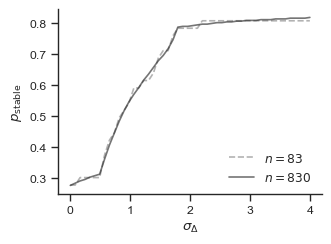

In [7]:
fig, ax = plt.subplots(figsize=(3.4, 2.4))

ax.set_xlabel(r"$\sigma_\Delta$")
ax.set_ylabel(r"$p_\mathrm{stable}$")


ax.plot(
    k2,
    stable_fraction1,
    linestyle="--",
    color="grey",
    alpha=0.6,
    label=r"$n=83$",
)
ax.plot(
    k2,
    stable_fraction2,
    linestyle="-",
    color="k",
    alpha=0.6,
    label=r"$n=830$",
)

# ax.set_xticks([0, 2, 4])
#ax.set_yticks([0.2, 0.5, 0.8])
#ax.set_ylim(ymin=0.18)


ax.legend(loc="lower right", frameon=False, ncol=1)

sb.despine()

#plt.savefig("stable_fraction.pdf")

## All together

/Users/maxime/.pyenv/versions/venv_xgi/lib/python3.9/site-packages/labellines/core.py:148: UserWarning: Tried to label line Line2D(_child5), but could not find a label for it.
  warnings.warn(


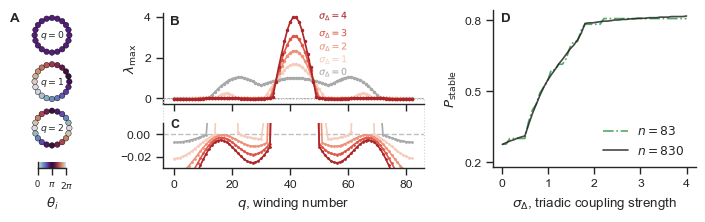

In [13]:
m = 5
N = 83
r = 2
r1 = 1
r2 = range(m)
Lambda_2 = np.zeros((N, m), dtype=np.complex_)

for q in range(N):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N, r1, r2[j], q, r)

# figure setup
fig = plt.figure(figsize=(7, 2.1), layout="constrained")
subfigs = fig.subfigures(1, 3, wspace=0.05, width_ratios=[1, 3, 2.5])

ax1 = subfigs[0].subplots(1, 1)
(ax, axins1) = subfigs[1].subplots(2, 1, height_ratios=[2, 1], sharex=False)
ax2 = subfigs[2].subplots(1, 1)


markers = ["o", "s", "p", "h", "d"]
labels = [rf"$\sigma_\Delta={i}$" for i in range(5)]
colors = ["darkgrey"] + sb.color_palette("Reds", n_colors=len(labels) - 1, desat=0.8)

# plot full spectrum
#####################

for i in range(m):
    ax.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker="o",  # "markers"[i],
        ms=1.5,
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )

ax.axhline(0, linestyle="--", alpha=0.6, c="k", zorder=-2, lw=0.5)
ax.set_ylabel(r"$\lambda_\mathrm{max}$")


from labellines import labelLine, labelLines

legs = labelLines(
    ax.get_lines(),
    zorder=2.5,
    xvals=[40] * 5,
    yoffsets=[0.29] * 6,  # [0.3] + [0.05] * 5,
    fontsize="x-small",
    align=False,
    outline_width=0.5,
    clip_on=False,
)
x_offset = 15
for leg in legs:
    x, y = leg.get_position()
    leg.set_position((x + x_offset, y))


# plot zoom in
##############

for i in range(m):
    axins1.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker="o",  # "markers"[i],
        ms=1,
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )

axins1.set_ylim(ymax=0.01, ymin=-0.03)
axins1.axhline(0, linestyle="--", alpha=1, c="silver", zorder=-1, lw=1)
axins1.set_ylabel("")
axins1.set_xlabel(r"$q$, winding number")

mark_inset(ax, axins1, loc1=2, loc2=4, ec="lightgrey", ls=":")

# plot Porder
#############

m = 50
N1 = 83
N2 = 830
r = 2
r1 = 1
r2 = np.linspace(0, 4, num=m)

Lambda_2 = np.zeros((N1, m), dtype=np.complex_)
for q in range(N1):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N1, r1, r2[j], q, r)
stable_fraction1 = np.mean(Lambda_2 < 0, axis=0)

Lambda_2 = np.zeros((N2, m), dtype=np.complex_)
for q in range(N2):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N2, r1, r2[j], q, r)
stable_fraction2 = np.mean(Lambda_2 < 0, axis=0)


ax2.set_xlabel(r"$\sigma_\Delta$, triadic coupling strength")
ax2.set_ylabel(r"$P_\mathrm{stable}$")


ax2.plot(
    r2,
    stable_fraction1,
    linestyle="-.",
    color="g",
    # alpha=0.6,
    label=r"$n=83$",
    zorder=2
)
ax2.plot(
    r2,
    stable_fraction2,
    linestyle="-",
    color="k",
    alpha=0.8,
    label=r"$n=830$",
)

ax2.set_yticks([0.2, 0.5, 0.8])
ax2.set_ylim(ymin=0.18)
axins1.set_yticks([0, -0.02])

ax.set_xticklabels([])

ax2.legend(loc="lower right", frameon=False, ncol=1)

# plot twisted states
#####################

N = 20

for q in range(3):
    psi = generate_q_twisted_state(N, q)
    H = xgi.trivial_hypergraph(N)

    pos = xgi.circular_layout(H, center=[0, -7.5 * q], radius=2.8)
    psi = psi % (2 * np.pi)
    _, im = xgi.draw_nodes(
        H,
        pos=pos,
        ax=ax1,
        node_fc=psi,
        vmin=0,
        vmax=2 * np.pi,
        node_fc_cmap="twilight",
        node_size=4,
        node_lw=0.3,
    )

    ax1.text(0, -7.5 * q, f"$q={q}$", fontsize="x-small", va="center", ha="center")


ax1.set_aspect("equal")

cbar = plt.colorbar(
    im,
    aspect=5,
    shrink=0.3,
    label=r"$\theta_i$",
    orientation="horizontal",
    location="bottom",
)
cbar.set_ticks(
    ticks=[0, np.pi, 2 * np.pi], labels=[0, r"$\pi$", r"$2\pi$"], fontsize="x-small"
)
cbar.outline.set_visible(False)

ax.text(0.03, 0.98, "B", transform=ax.transAxes, va="top", ha="left", weight="bold")
axins1.text(0.03, 1.1, "C", transform=axins1.transAxes, va="top", ha="left", weight="bold", fontsize=9)
ax2.text(0.04, 0.98, "D", transform=ax2.transAxes, va="top", ha="left", weight="bold")
ax1.text(-0.5, 0.98, "A", transform=ax1.transAxes, va="top", ha="left", weight="bold")


sb.despine()

plt.savefig("../results/figure_1.pdf", dpi=250, bbox_inches="tight", pad_inches=0)